In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [8]:
X, y = load_diabetes(return_X_y=True)
X = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X)

X_tensor = torch.tensor(X_pca, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
x_params = ParameterVector("x", 2)
theta_params = ParameterVector("θ", 2)
qc = QuantumCircuit(2)
for i in range(2):
    qc.ry(x_params[i], i)
qc.cx(0, 1)
for i in range(2):
    qc.ry(theta_params[i], i)

observables = [
    SparsePauliOp.from_list([("ZI", 1)]),
    SparsePauliOp.from_list([("IZ", 1)]),
]

In [10]:
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=x_params,
    weight_params=theta_params,
    estimator=estimator,
    observables=observables
)
qnn_layer = TorchConnector(qnn)

In [11]:
model = nn.Sequential(
    qnn_layer,
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

In [12]:
def main():
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.05)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

    num_epochs = 100

    loss_history = []
    r2_scores = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in dataloader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        scheduler.step()
        epoch_loss /= len(X_tensor)
        loss_history.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_tensor).squeeze().numpy()
            r2 = r2_score(y, y_pred)
            r2_scores.append(r2)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}, R² Score = {r2:.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(loss_history, label='Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("QNN Loss on Diabetes Dataset (2 Qubits)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(r2_scores, label='R² Score')
    plt.xlabel("Epoch")
    plt.ylabel("R² Score")
    plt.title("QNN R² Score Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

Epoch 0: Loss = 22844.4056, R² Score = -0.3529
Epoch 10: Loss = 5507.0650, R² Score = 0.0872
Epoch 20: Loss = 5368.3724, R² Score = 0.0993
Epoch 30: Loss = 5518.2037, R² Score = 0.0952
Epoch 40: Loss = 5392.5220, R² Score = 0.0992
Epoch 50: Loss = 5344.5072, R² Score = 0.1094
Epoch 60: Loss = 5443.7235, R² Score = 0.0982
Epoch 70: Loss = 5328.1716, R² Score = 0.1044
Epoch 80: Loss = 5364.1736, R² Score = 0.0847
Epoch 90: Loss = 5460.0204, R² Score = 0.1030


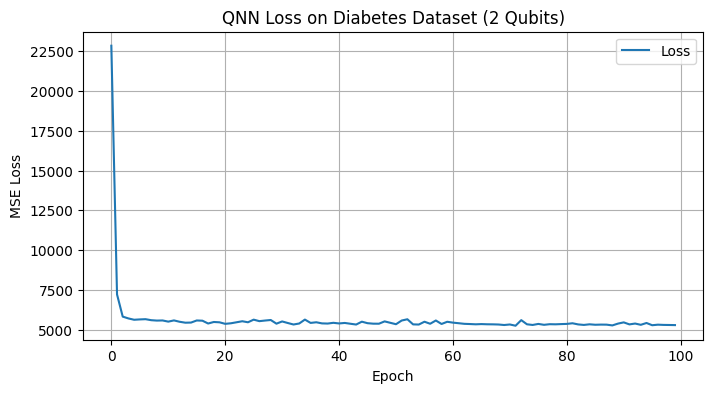

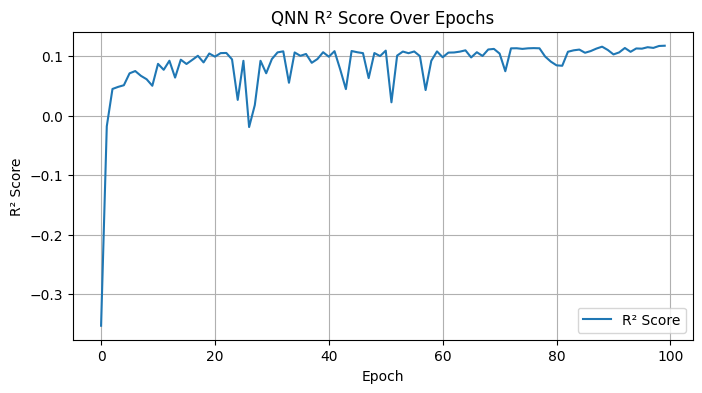

In [13]:
if __name__ == "__main__":
    main()